# Working with the Python DASK library

Mat Larade -- mat.larade@ace-net.ca

## Notes about the slides ...

They are in a Jupyter notebook using the RISE extension.

https://github.com/ualberta-rcg/wg-dask-webinar

RISE stands for Reveal.js - Jupyter/IPython Slideshow Extension

https://rise.readthedocs.io/en/maint-5.5/
    
Template shamelessly ripped from one chris want christ.want@ualberta.ca

## Other resources

I won't be doing a comprehensive overview Dask.
Here is some good supplimental material:
* Sharcnet webinar (last week) by Jinhui Qin
  * Great overview of Dask
  * https://youtube.sharcnet.ca
* U of A Workshop
  * https://ualberta-rcg.github.io/python-dask/
* Google for `dask tutorial`
  * Lots of good notebooks in a Github repository

## Python - General

* Python is an interperted software language that has a great deal of support in scientific and mathematical computing

* Two of the major packages we will be referencing today are Numpy and Pandas

In [38]:
#import a small dataset from SKLearn for later
from sklearn import datasets
iris_data = datasets.load_iris()
iris_attributes = iris_data.data
iris_classes = iris_data.target

## DASK - General

Dask is a lazy framework that automates parallel operations. Lazy, meaning that it doesn’t operate until it is told to.

Dask is conceptually similar to a dishwasher\*, where it will wait idle until it’s told to do everything all at once**.

*Using Dask does not guarantee your code will be clean.

**Not everything actually done all at once, Dask does several things at once.

Dask can operate as it’s own task manager in one of three ways:
1. Threaded – Using small, independent chunks of code running in the same instance of a computer program. Best for operations on numerical data that doesn’t keep a Global Interpreter Lock (e.g. Numpy, Pandas, Scikit-Learn).
2. Processes – Sends data to separate instances of a program to be processed.  Generally works best when there are several instances of a program running at simultaneously that hold the Global Interpreter Lock.
3. Single-Threaded – Does one chunk of code at a time, with no parallel capacity. Primarily for Debugging.


* We begin by spawning a client.  There are several different ways of doing this, however, we will be using a 4-core, 1 worker cluster, with a memory limit of 2GB of memory (adjust the memory req for whatever you can spare if you need to).
* This client will open up a "Dashboard" which you can use to monitor what's going on under the hood of your DASK instance.
* If you'd like to read more about specific clients, and how they operate, please refer to https://distributed.dask.org/en/latest/ as these features are difficult to use effectively on HPC systems

In [40]:
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Client Scheduler: inproc://192.168.0.5/5012/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 2.00 GB


## An artist's rendition of DASK before running based on my description
<left>![](./Picture1.png)</left>

## Dask - Delayed

* The Delayed command holds back the operations and assigns them to different cores.
* Rather than waiting for tasks to finish sequentially, initial tasks are assigned to different cores that operate simultaneously. 
* When a core finishes it’s job, it gets a new operation. 
* Similar to customs in an Airport.

![](./Picture2.gif)

## Dask - Delayed

We are going to demonstrate how dask.delayed works using an increment function that takes one second to execute, and and add function that takes one second to execute.

In [39]:
from time import sleep
from dask import delayed

def increment(x):
    sleep(1)
    return x + 1

def add(x, y):   
    sleep(1)
    return x +  y

In [33]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other

x = increment(1)
y = increment(2)
z = add(x, y)

Wall time: 3 s


In [35]:
%%time
# This runs immediately, all it does is build a graph

x = delayed(increment)(1)
y = delayed(increment)(2)
z = delayed(add)(x, y)

Wall time: 0 ns


In [36]:
%%time
# This actually runs our computation using a local process pool

z.compute()

Wall time: 2.03 s


5

In [37]:
z.visualize()

RuntimeError: Drawing dask graphs requires the `graphviz` python library and the `graphviz` system library to be installed.

## Dask - Bagging

* Bagging works by taking semi-structured data and preparing that data to be operated on in parallel.
* Bags work on what they have to at any given time, so once a data chunk is processed, it is removed from memory, thus reducing the overall footprint of operations.

## Portions up your data so you can...
![](./Picture4.jpg)

## You can run more data through faster than single threads
 
![](./Picture3.jpg)
*in the metaphor, each core is it's own pizza oven

In [38]:
from dask import bag
bag1 = bag.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)
bag1.take(3)

(1, 2, 3)

`Bag` objects hold the standard functional API found in projects like the Python standard library, `toolz`, or `pyspark`, including `map`, `filter`, `groupby`, etc..

Operations on `Bag` objects create new bags.  Call the `.compute()` method to trigger execution, as we saw for `Delayed` objects.  

In [39]:
def is_even(n):
    return n % 2 == 0

In [40]:
%%time
bag2 = bag.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
filtered_bag2 = bag2.filter(is_even).map(lambda x: x ** 2)
filtered_bag2.compute()

Wall time: 42 ms


[4, 16, 36, 64, 100]

In [41]:
sequence = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
even_sequence = []
%time
for item in sequence:
     if is_even(item):
        even_sequence.append(item**2)
print(even_sequence)

Wall time: 0 ns
[4, 16, 36, 64, 100]


## Numpy

![](./Math.jpg)

* Numpy is a widely used and comprehensive mathematics package in python
* Numpy stands for "Numerical Python", and handles tasks such as matrix math, trig, linear algebra, etc.
* Is very useful for matrix math, and matrix-like operations, such as loading data into machine learning algorithms
* This talk will not deep-dive into numpy, but will instead talk about a few key features, give a rough idea of what numpy is capable of, before moving on to dask arrays

In [3]:
import numpy as np

## Numpy

* Numpy primarily works on arrays of data, though several functions can be called on intigers or floats.
* Arrays may have between 1 and n dimensions, and are primarily limited in size by the amount of ram a computer has to operarte on them.
* We will walk through a quick example on how to create a numpy arrray, then pass it over to DASK.

In [8]:
array = np.arange(16)
print(array)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [10]:
array2 = array.reshape(4,4)
print(array2)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [11]:
print(array.shape)
print(array2.shape)

(16,)
(4, 4)


## Numpy 
* Numpy has most of the mathematical functions that one could ask for, a non-exhaustive list includes


* Numpy backs onto well-written, compiled software, so it performs faster and more reliable calculations than most code you can write yourself

## Dask - Arrays

* Dask arrays are a multidimensional, structured data format that are useful for manipulating large amounts of numerical data. 
* Dask arrays are distributed Numpy arrays.
* Dask arrays can be manipulated in parallel.
* Much of the syntax for Dask arrays is lifted directly from numpy

In [35]:
from dask import array as da

dask_array = da.from_array(array2) 

In [36]:
iris_attributes_dask = da.from_array(iris_attributes)

NameError: name 'iris_attributes' is not defined

In [37]:
da.mean(iris_attributes_dask)

NameError: name 'iris_attributes_dask' is not defined

In [25]:
%%time
np.mean(iris_attributes)

NameError: name 'iris_attributes' is not defined

In [26]:
x = da.random.random((10000, 10000), chunks=(1000, 1000))
z = da.mean(x)

In [32]:
%%time
z.compute()

Wall time: 116 ms


0.5000484232194616

You can also force DASK arrays to hold the data in memory as well, using the persist command

In [30]:
x_persist = x.persist()
z_persist = da.mean(x_persist)

In [34]:
%%time
#Old time was ~116ms
z_persist.compute()

Wall time: 107 ms


0.5000484232194616

## Dask - Arrays: Limitations

* Not all of numpy is included in dask, specifically sorting, listing, and some smaller functions
* Dask tends to be slightly slower than loading the entire dataset into memory

## Dask arrays allows you to move mountians
![](./Picture6.jpg)

## A bucket of rocks at a time
![](./Picture5.jpg)

## Python - Pandas

![](./Panda.jpg)

* Pandas is effectively a spreadsheeting program for python, running on Python/Cython/C.
* Pandas is similar to Excel, but does not have a GUI, so it is faster, but less user friendly.
* Pandas tends to operate more quickly and efficiently than full-fat Microsoft Excel.
* Pandas operates primarily using DataFrames, rougly equivalent to Excel Sheets.

In [47]:
#The data is the google search trends for the word "parallel"
import pandas as pd

pandas_dataframe = pd.read_csv('multiTimeline.csv')
print(pandas_dataframe.head())

             Category: All categories
Week        parallel: (United States)
2019-06-02                         25
2019-06-09                         23
2019-06-16                         22
2019-06-23                         21


Pandas offers much of the same functionality as Excel, except you need to print out data as you go.

In [9]:
print(pandas_dataframe.columns.values)
print(pandas_dataframe.index.values)

['Category: All categories']
['Week' '2019-06-02' '2019-06-09' '2019-06-16' '2019-06-23' '2019-06-30'
 '2019-07-07' '2019-07-14' '2019-07-21' '2019-07-28' '2019-08-04'
 '2019-08-11' '2019-08-18' '2019-08-25' '2019-09-01' '2019-09-08'
 '2019-09-15' '2019-09-22' '2019-09-29' '2019-10-06' '2019-10-13'
 '2019-10-20' '2019-10-27' '2019-11-03' '2019-11-10' '2019-11-17'
 '2019-11-24' '2019-12-01' '2019-12-08' '2019-12-15' '2019-12-22'
 '2019-12-29' '2020-01-05' '2020-01-12' '2020-01-19' '2020-01-26'
 '2020-02-02' '2020-02-09' '2020-02-16' '2020-02-23' '2020-03-01'
 '2020-03-08' '2020-03-15' '2020-03-22' '2020-03-29' '2020-04-05'
 '2020-04-12' '2020-04-19' '2020-04-26' '2020-05-03' '2020-05-10'
 '2020-05-17' '2020-05-24']


You can print out data from a specific locus or from a pair of headings

In [22]:
i=5
j=0
print(pandas_dataframe.iloc[i, j])
print(pandas_dataframe.loc['2019-07-07', 'Category: All categories'])

18
20


You can get a dump of the information about a dataframe, such as what it contains and the datatypes stored inside of it.

In [23]:
print(pandas_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, Week to 2020-05-24
Data columns (total 1 columns):
Category: All categories    53 non-null object
dtypes: object(1)
memory usage: 3.3+ KB
None


You can also have pandas crunch some bulk statistics on your data.

In [24]:
pandas_dataframe.describe()

,Category: All categories
count,53
unique,25
top,35
freq,6


You can also perform excel functions/operations on data such as plotting.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

In [44]:
print(pandas_dataframe.iloc[1:,0])
print(type(pandas_dataframe.iloc[1,0]))

2019-06-02     25
2019-06-09     23
2019-06-16     22
2019-06-23     21
2019-06-30     18
2019-07-07     20
2019-07-14     21
2019-07-21     21
2019-07-28     19
2019-08-04     19
2019-08-11     21
2019-08-18     24
2019-08-25     26
2019-09-01     27
2019-09-08     32
2019-09-15     34
2019-09-22     34
2019-09-29     36
2019-10-06     35
2019-10-13     33
2019-10-20     35
2019-10-27     35
2019-11-03     33
2019-11-10     32
2019-11-17     32
2019-11-24     21
2019-12-01     31
2019-12-08     32
2019-12-15     29
2019-12-22     13
2019-12-29     15
2020-01-05     26
2020-01-12     28
2020-01-19     29
2020-01-26     31
2020-02-02     34
2020-02-09     34
2020-02-16     34
2020-02-23     36
2020-03-01     35
2020-03-08     31
2020-03-15     24
2020-03-22     29
2020-03-29     35
2020-04-05     33
2020-04-12     34
2020-04-19     38
2020-04-26     38
2020-05-03     37
2020-05-10     35
2020-05-17    100
2020-05-24     44
Name: Category: All categories, dtype: object
<class 'str'>


In [45]:
pandas_dataframe.iloc[1:,0] = pandas_dataframe.iloc[1:,0].astype(int)
print(type(pandas_dataframe.iloc[1,0]))

<class 'int'>


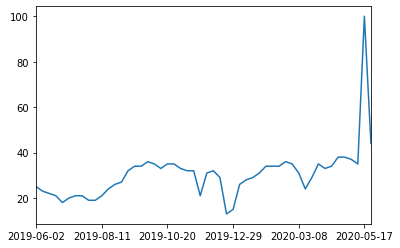

In [46]:
pandas_dataframe.iloc[1:,0].plot()

## Dask - When to use DataFrames (from the Dask documentation)

Dask DataFrames are used in situations where Pandas is commonly needed, but when Pandas is inadequare due to:

* Manipulating large datasets, even when those datasets don’t fit in memory
* Accelerating long computations by using many cores
* Distributed computing on large datasets with standard Pandas operations like groupby, join, and time series computations

In [48]:
import dask.dataframe as dd

In [49]:
dask_dataframe = dd.read_csv('multiTimeline.csv')

## Dask DataFrames Anti-Uses

Dask DataFrame may not be the best choice in the following situations:

* If your dataset fits into RAM on your laptop, just using Pandas. There are probably simpler ways to improve performance than  parallelism.
* If your dataset doesn’t fit neatly into the Pandas tabular model, then you might find more use in dask.bag or dask.array.
* If you need functions that are not implemented in Dask DataFrame, then you might want to look at dask.delayed which offers more flexibility.
* If you need all of the features that databases offer you should consider PostgresSQL or MySQL.